#### *Applied Mathematical Finance 2*

#### *Makhova Anastasia*

## <ins> *Lab 1: Handling Dividends* </ins>

The deadline is 23:59 on 6th of April, 2025. The solution must be sent up to the deadline on amf2-2025-spring@yandex.ru.


### 1. Cash Dividend Model naive Monte-Carlo (45 points)

Consider the Cash Dividend Model where the stock price dynamics in-between ex-dividend dates $0 < \tau_1 < \cdots < \tau_n < T$ under the risk-neutral measure $\mathbb{Q}$ is given by 


$$dS_t/S_t = rdt + \sigma dW^{\mathbb{Q}}_t, \quad t \in [\tau_{i-1}, \tau_i),$$
$$S_{\tau_{i}-} - S_{\tau_{i}} = d_i.$$

Assume that the initial spot price is $S_0 = 100 \$$, the risk-free interest rate $r=15\%$ and the volatility $\sigma = 25\%$. Also, assume that the stock pays $5\$$ cash dividends in the middle of each year (for the sake of simplicity, assume that there is no dividends payment lag). 

1. **(10 points)** Compute a forward curve $(F_{0, t})_{t \in [0, T]}$. Your answer should contatin a plot of a forward curve. Assume that $T = 5$ years. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Callable, Any, Union
import warnings
warnings.filterwarnings('ignore')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [2]:
S0 = 100
r = 0.15
sigma = 0.25
alpha = 5
beta = 0
T = 5

In [3]:
#dates = np.linspace(0, T, T*2+1)

p_dates = np.arange(0.5, T, 1) #payment dates
dates = np.linspace(0, T, 100+1)#dates = np.pad(p_dates, (1, 1), 'constant', constant_values=(0, T)) #dates for F(0, .)

In [4]:
for t in p_dates:
    if t in dates:
        print(t)

0.5
1.5
2.5
3.5
4.5


from lecture notes (in case without dividend payment lag):
$$
\begin{cases}
F_t^T = S_t R(t, T) - \sum_{i: t < \tau_i < T} \alpha_i R(\tau_i, T)\\
R(t, T) = e^{\int_t^T(r_s - \mu_s)ds}\prod_{t < \tau_i \leq T}(1-\beta_i)
\end{cases}
$$
as $\beta_i = 0$ and $\alpha = const$: 
 $$F_0^t = S_0 e^{\int_0^t(r_s - \mu_s)ds} - \alpha \sum_{i: 0 < \tau_i < t} e^{\int_{\tau_i}^t(r_s - \mu_s)ds} \\ = S_0 e^{t r} - \alpha \sum_{i: 0 < \tau_i <  t} e^{(t -\tau_i)r} $$

In [5]:
def compute_forward_curve(S0: float = 100,
                          r: float = 0.15,
                          dividend: float = 5.0,
                          dividend_times: np.ndarray = np.linspace(0.5, 4.5, 5),
                          T: float = 5.0,
                          num_points: int = 500) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the forward curve F0,t on [0, T] under fixed cash dividends.

    Returns:
        t_grid: time points
        F_grid: forward prices at each time
    """
    t_grid = np.linspace(0, T, num_points)
    F_grid = np.zeros_like(t_grid)

    for j, t in enumerate(t_grid):
        discounted_divs = sum(dividend * np.exp(r * (t - tau))
                              for tau in dividend_times if tau <= t)
        F_grid[j] = S0 * np.exp(r * t) - discounted_divs

    return t_grid, F_grid

In [6]:
def F_0_t(S0, r, t, alpha,p_dates):
    return S0*np.exp(r*t) - alpha *sum([ np.exp(r * (t - tau)) for tau in p_dates if tau <= t])

In [7]:
def forvard_curve_simple(S0, r, alpha, dates, p_dates):
    F = []
    for t in dates:
        F.append(F_0_t(S0, r, t, alpha, p_dates))
    return np.array(F)

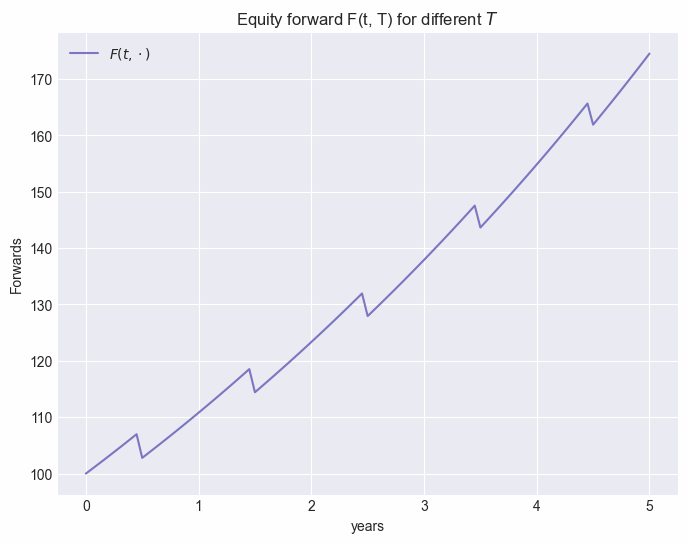

In [8]:
F = forvard_curve_simple(S0, r, alpha, dates, p_dates)
plt.figure(figsize=(8, 6))
plt.title("Equity forward F(t, T) for different $T$")
plt.plot(dates, F, label="$F(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("Forwards")
plt.grid(True)
plt.legend()
plt.show()

------
 Alternative version within the code from seminar 1

In [9]:
risk_free_rates = np.full(len(dates), r)
repo_rates = np.zeros(len(dates))

In [10]:
def discount_factors_on_pillar_dates(dates: np.ndarray, rates: np.ndarray):
    """
    Returns discount factors for pillar dates. 

    Args: 
        dates: dates at which the discount factors are computed. 
        rates: zero-rates from which the discount factors are transformed. 
    """
    return np.exp(- dates * rates) # Assume continous compounding convention.

In [11]:
risk_free_dfs = discount_factors_on_pillar_dates(dates=dates, rates=risk_free_rates)
repo_dfs = discount_factors_on_pillar_dates(dates=dates, rates=repo_rates)

In [12]:
def build_dicount_factor_curve_based_on_pillar_discount_factors(dates: np.ndarray, discount_factors: np.ndarray):
    """
    Build discount factor curve based on pillar discount factors. Linear interpolation in log(DF(t, T)) wrt T assumed. 

    Args: 
        dates: dates at which the discount factors are given. 
        discount: the discount factors to interpolate. 
    """
    log_discount_factors = np.log(discount_factors)
    intepolator = interp1d(x=dates, y=log_discount_factors, kind="linear", fill_value="extrapolate")
    return lambda x: np.exp(intepolator(x))

In [13]:
risk_free_dfs_curve = build_dicount_factor_curve_based_on_pillar_discount_factors(dates=dates, discount_factors=risk_free_dfs)
repo_dfs_curve = build_dicount_factor_curve_based_on_pillar_discount_factors(dates=dates, discount_factors=repo_dfs)

In [14]:
def get_discounted_dividends(alphas: np.ndarray, betas: np.ndarray, t_ex: np.ndarray, t_p: np.ndarray, 
                             risk_free_dfs_curve: Callable[[float], float], repo_dfs_curve: Callable[[float], float]):
    """
    Calculates the discounted dividends $\bar alpha_t$, $\bar \beta_t$, i.e. effectively discounts 
    the dividends from payment dates to ex-dividend dates. 

    Args:
        alphas: fixed dividends. 
        betas: proportional dividends. 
        t_ex: ex-dividend dates. 
        t_p: payment dates.
        risk_free_dfs_curve: the risk-free rate discount factor curve.
        repo_dfs_curve: the repo-rate discount factor curve. 
    """
    alphas_disc = np.zeros_like(alphas)
    betas_disc = np.zeros_like(betas)
    
    for i, (t_ex_i, t_p_i) in enumerate(zip(t_ex, t_p)):
        carry_rate = (risk_free_dfs_curve(t_p_i) /  risk_free_dfs_curve(t_ex_i)) / (repo_dfs_curve(t_p_i) /  repo_dfs_curve(t_ex_i))
        alphas_disc[i] = alphas[i] * carry_rate
        betas_disc[i] = betas[i] *  carry_rate

    return alphas_disc, betas_disc

In [15]:
t_ex = p_dates # ex-dividend dates
t_p = p_dates #  payment date
alphas = np.full(len(p_dates), alpha)# fixed dividends
betas = np.full(len(p_dates), beta) # proportional dividends

In [16]:
alphas_disc, betas_disc = get_discounted_dividends(alphas=alphas, betas=betas, t_ex=t_ex, t_p=t_p, 
                                                   risk_free_dfs_curve=risk_free_dfs_curve, 
                                                   repo_dfs_curve=repo_dfs_curve)

In [17]:
def effective_carry_rate(t_ex: np.ndarray, betas_disc: np.ndarray, 
                         risk_free_dfs_curve: Callable[[float], float], 
                         repo_dfs_curve: Callable[[float], float]): 
    """
    Calculates the effective carry rate R(t, T). 

    Args: 
        t_ex: ex-dividend dates. 
        betas_disc: discounted from t_p to t_ex proportional dividends.
        risk_free_dfs_curve: the risk-free rate discount factor curve.
        repo_dfs_curve: the repo-rate discount factor curve.
    """
    betas_disc_complement = 1 - betas_disc
    return lambda t, T : (repo_dfs_curve(T) / repo_dfs_curve(t)) / (risk_free_dfs_curve(T) / risk_free_dfs_curve(t)) * np.prod(betas_disc_complement[(t < t_ex) &  (t_ex <= T)])

In [18]:
R = effective_carry_rate(t_ex=t_ex, betas_disc=betas_disc, 
                         risk_free_dfs_curve=risk_free_dfs_curve, 
                         repo_dfs_curve=repo_dfs_curve)

In [19]:
def cash_divs_present_value(t_ex: np.ndarray, alphas_disc: np.ndarray, R: Callable[[float, float], float]): 
    """
    Calculates the present value of cash dividends Div(t, T). 

    Args: 
        t_ex: ex-dividend dates. 
        alphas_disc: discounted from t_p to t_ex fixed dividends.
        R: carry rate. 
    """
    return lambda t, T: np.sum((alphas_disc / R(t, t_ex))[(t < t_ex) & (t_ex <= T)])

In [20]:
Div = cash_divs_present_value(t_ex=t_ex, alphas_disc=alphas_disc, R=R)

In [21]:
def equity_forward(S_ref: float, Div: Callable[[float, float], float], R: Callable[[float, float], float]):
    """
    Calculates the equity forward F(t, T).  

    Args: 
        S_ref: spot value. 
        Div: present value of cash dividends. 
        R: carry rate. 
    """
    return np.vectorize(lambda t, T: R(t, T) * (S_ref - Div(t, T)))

In [22]:
equity_forward_curve = equity_forward(S_ref=S0, Div=Div, R=R)

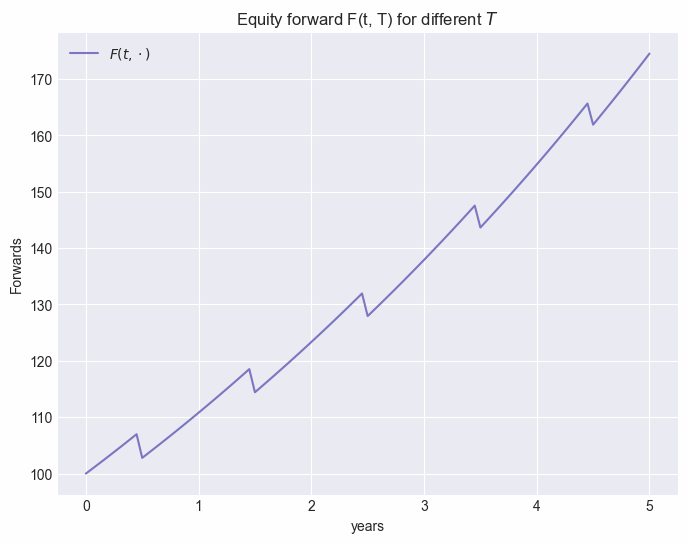

In [23]:
plt.figure(figsize=(8, 6))
plt.title("Equity forward F(t, T) for different $T$")
plt.plot(dates, equity_forward_curve(0, dates), label="$F(t, \cdot)$")
plt.xlabel("years")
plt.ylabel("Forwards")
plt.grid(True)
plt.legend()
plt.show()

$F(0, T)$ are equal in both methods:

In [24]:
print(f'F(0, T) = {equity_forward_curve(0, T)} = {F_0_t(S0, r, T, alpha, p_dates)}' )

F(0, T) = 174.50155113104927 = 174.50155113104933


2. **(15 points)** Using the Monte-Carlo method method, obtain the prices of vanilla options (in terms of Black implied volatilities) with maturity $T=5$ years. Use the strikes $K$ ranging from $40$ to $160$ with step $5$. Your answer should contain an implied volatilities curve plot.

In [25]:
T = 5
K = np.arange(40, 160, 5) 
n_paths = 2**20

In [26]:
#чтобы ускорить передайте dates = np.pad(p_dates, (1, 1), 'constant', constant_values=(0, T))
def mc_S_T(S0, r, sigma, n_paths, dates, p_dates, alpha):
    np.random.seed(99)
    S_T = np.full(n_paths, S0)
    for i in range(1,len(dates)): #в нулевой момент выплаты нет
        Z = np.random.normal(size = n_paths)
        dt = dates[i]- dates[i-1]
        S_T = S_T* np.exp((r-0.5*sigma**2)*dt +  sigma*np.sqrt(dt)*Z)
        if dates[i] in p_dates: S_T = S_T-alpha
    #S_T += alpha #в последний момент тоже нет выплаты
    return S_T

In [27]:
def mc_call(S0, r, sigma, T, n_paths,dates, p_dates, alpha, K):
    S_T = mc_S_T(S0, r, sigma,  n_paths, dates, p_dates, alpha)
    payoff = np.maximum(S_T-K, 0)
    return np.exp(-r*T) *np.mean(payoff)

In [28]:
from scipy.stats import norm
from scipy.optimize import brentq

In [29]:
def black_call_price(F, K, T, r, sigma):
    d1 = np.log(F / K)/ (sigma * np.sqrt(T)) + 0.5 * sigma * np.sqrt(T) 
    d2 = np.log(F / K)/ (sigma * np.sqrt(T)) - 0.5 * sigma * np.sqrt(T) 
    return np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))

In [30]:
def implied_vol_black(price, F, K, T, r):
    try:
        return brentq(lambda sigma: black_call_price(F, K, T, r, sigma) - price,
                      a=1e-6, b=1.0)
    except:
        return np.nan


In [31]:
fast_dates = np.pad(p_dates, (1, 1), 'constant', constant_values=(0, T))
F = equity_forward_curve(0, T)
mc_prices = [mc_call(S0, r, sigma, T, n_paths, fast_dates,p_dates, alpha, k) for k in K]
iv_black = [implied_vol_black(p, F, k, T, r) for p, k in zip(mc_prices, K)]


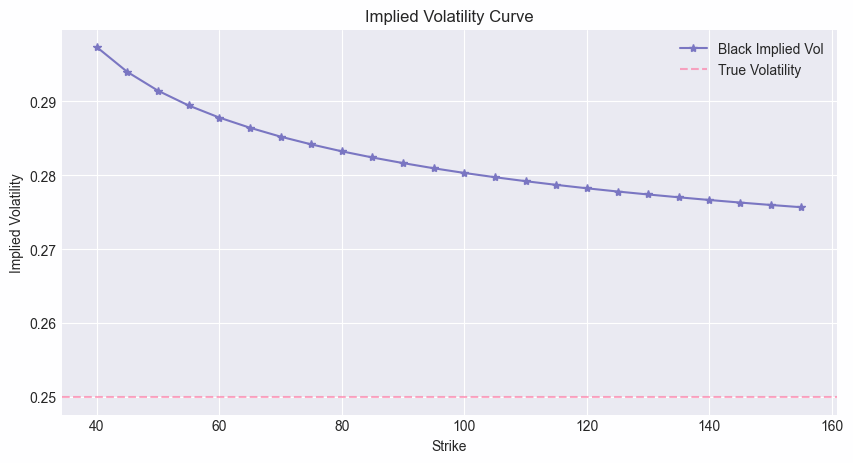

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(K, iv_black, label="Black Implied Vol", marker='*')
plt.axhline(sigma, linestyle='--', color='C1', label='True Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Curve")
plt.grid(True)
plt.legend()
plt.show()

I don`t like the ``smile'' above. Another method: 

P.S. with different seeds there are different smiles. For example, with seed = 42 we have ':('  and with 99 ':/'

In [33]:
from py_vollib.black.implied_volatility import implied_volatility

ivs = []

for i in range(len(mc_prices)):
    try:
        vol = implied_volatility(
            discounted_option_price=mc_prices[i],       
            F = F,           
            K=K[i],       
            r=r,         
            t=T,  # Время до экспирации
            flag='c'     # Тип опциона ('c' - call)
        )
        ivs.append(vol)
    except Exception as e:
        print(f"Ошибка на strike={K[i]}: {e}")
        ivs.append(np.nan)  

implied_vols = np.array(ivs)

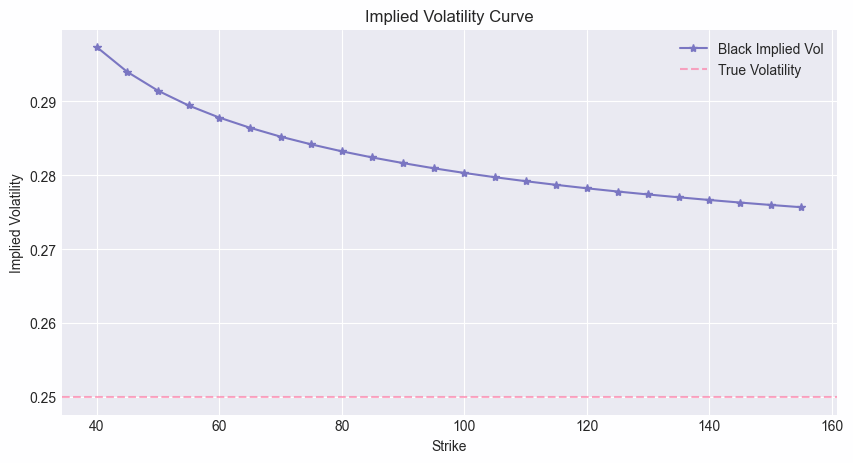

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(K, implied_vols, label="Black Implied Vol", marker='*')
plt.axhline(sigma, linestyle='--', color='C1', label='True Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Curve")
plt.grid(True)
plt.legend()
plt.show()

Nothing has changed. I suppose we`ve got the right smile :/ 

Let`s check the correctness of Call prices

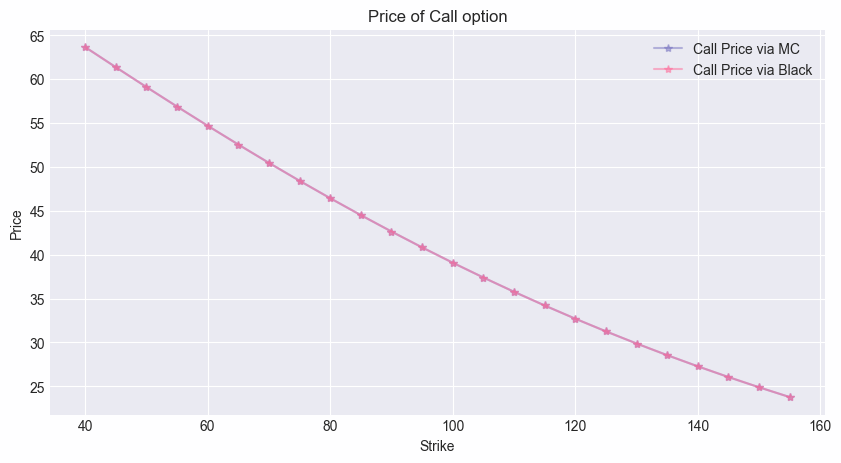

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(K, mc_prices, label="Call Price via MC", marker='*', alpha = 0.5)
plt.plot(K,black_call_price(F, K, T, r, implied_vols), label="Call Price via Black", marker='*', alpha = 0.5)

plt.xlabel("Strike")
plt.ylabel("Price")
plt.title("Price of Call option")
plt.grid(True)
plt.legend()
plt.show()

3. **(10 points)** Show that your Monte-Carlo algorithm converges in terms of decreasing empirical (relative) error when the number of simulations increases. Your answer should contain a plot of error as a function of number of simulations. 


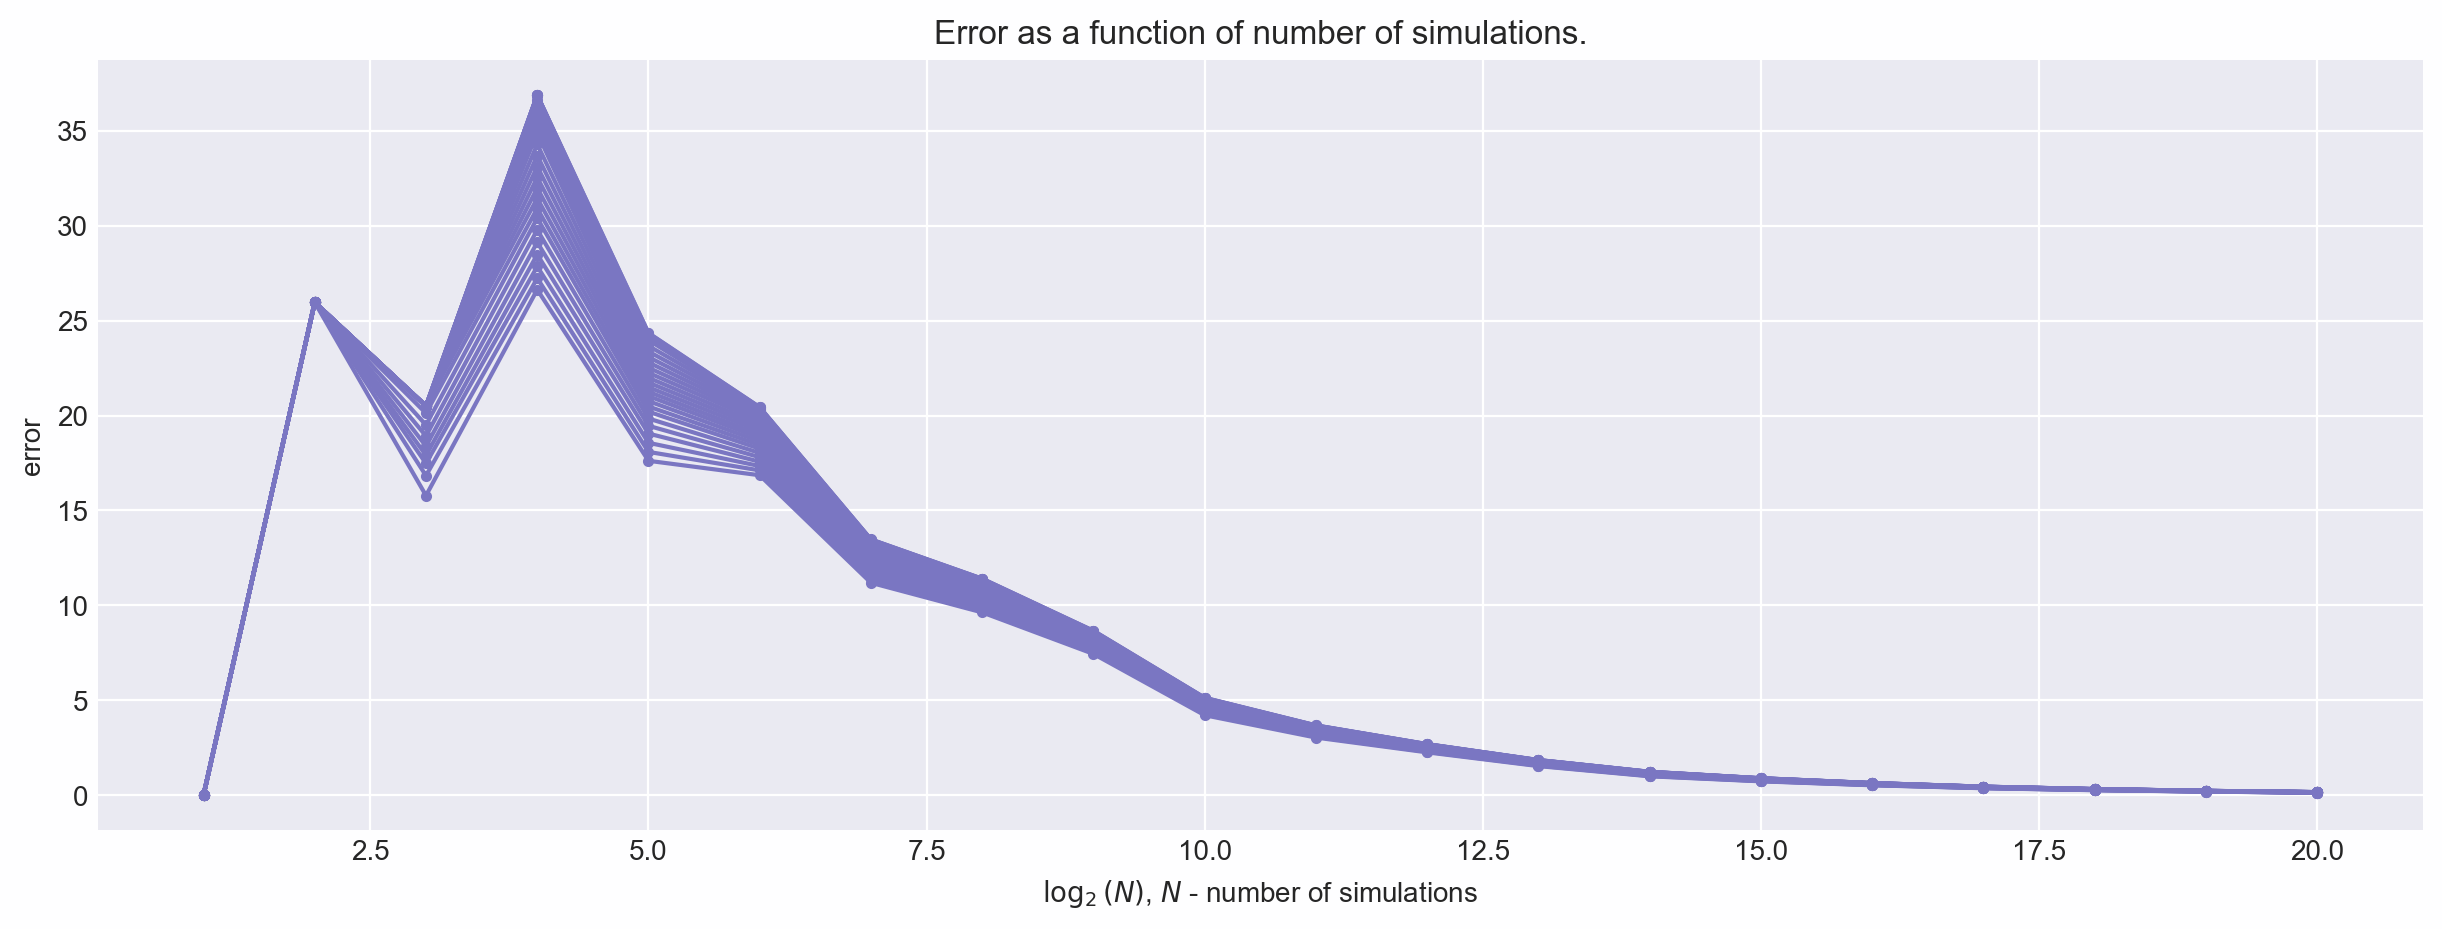

In [36]:

log_2_iteratinos = np.linspace(1, 20, 20)
N = [2**i for i in range(log_2_iteratinos.shape[0])]
one_over_sqrt_N = 1 / np.sqrt([2**i for i in range(log_2_iteratinos.shape[0])])

_, ax = plt.subplots(figsize=(15, 5), dpi=200)

for k in K:
    errors = []
    for n_paths in N:
        #payoff = mc_call(S0, r, sigma, T, n_paths, dates, alpha, k)
        #errors.append(payoff) #np.abs(errors - errors[-1])
        payoff = np.maximum(mc_S_T(S0, r, sigma, n_paths, fast_dates,p_dates, alpha) - k,0)
        errors.append(np.std(payoff)/np.sqrt(n_paths))
    ax.plot(log_2_iteratinos, errors , marker = '.',color = 'C0', label=f"K = {k}")

#ax.plot(log_2_iteratinos, np.abs(one_over_sqrt_N - one_over_sqrt_N[-1]), label="$1/\\sqrt{N}$", marker="*", linestyle="--")
ax.set_title('Error as a function of number of simulations.')
ax.set_xlabel("$\\log_2(N)$, $N$ - number of simulations")
ax.set_ylabel('error')
#plt.legend()
plt.show()

4. **(10 points)** As a sanity check of your simulations algorithm, show that the empirically averaged stock price $S_T$ converges to a forward price $F_{0, T}$ when number of monte carlo simulations increases. 

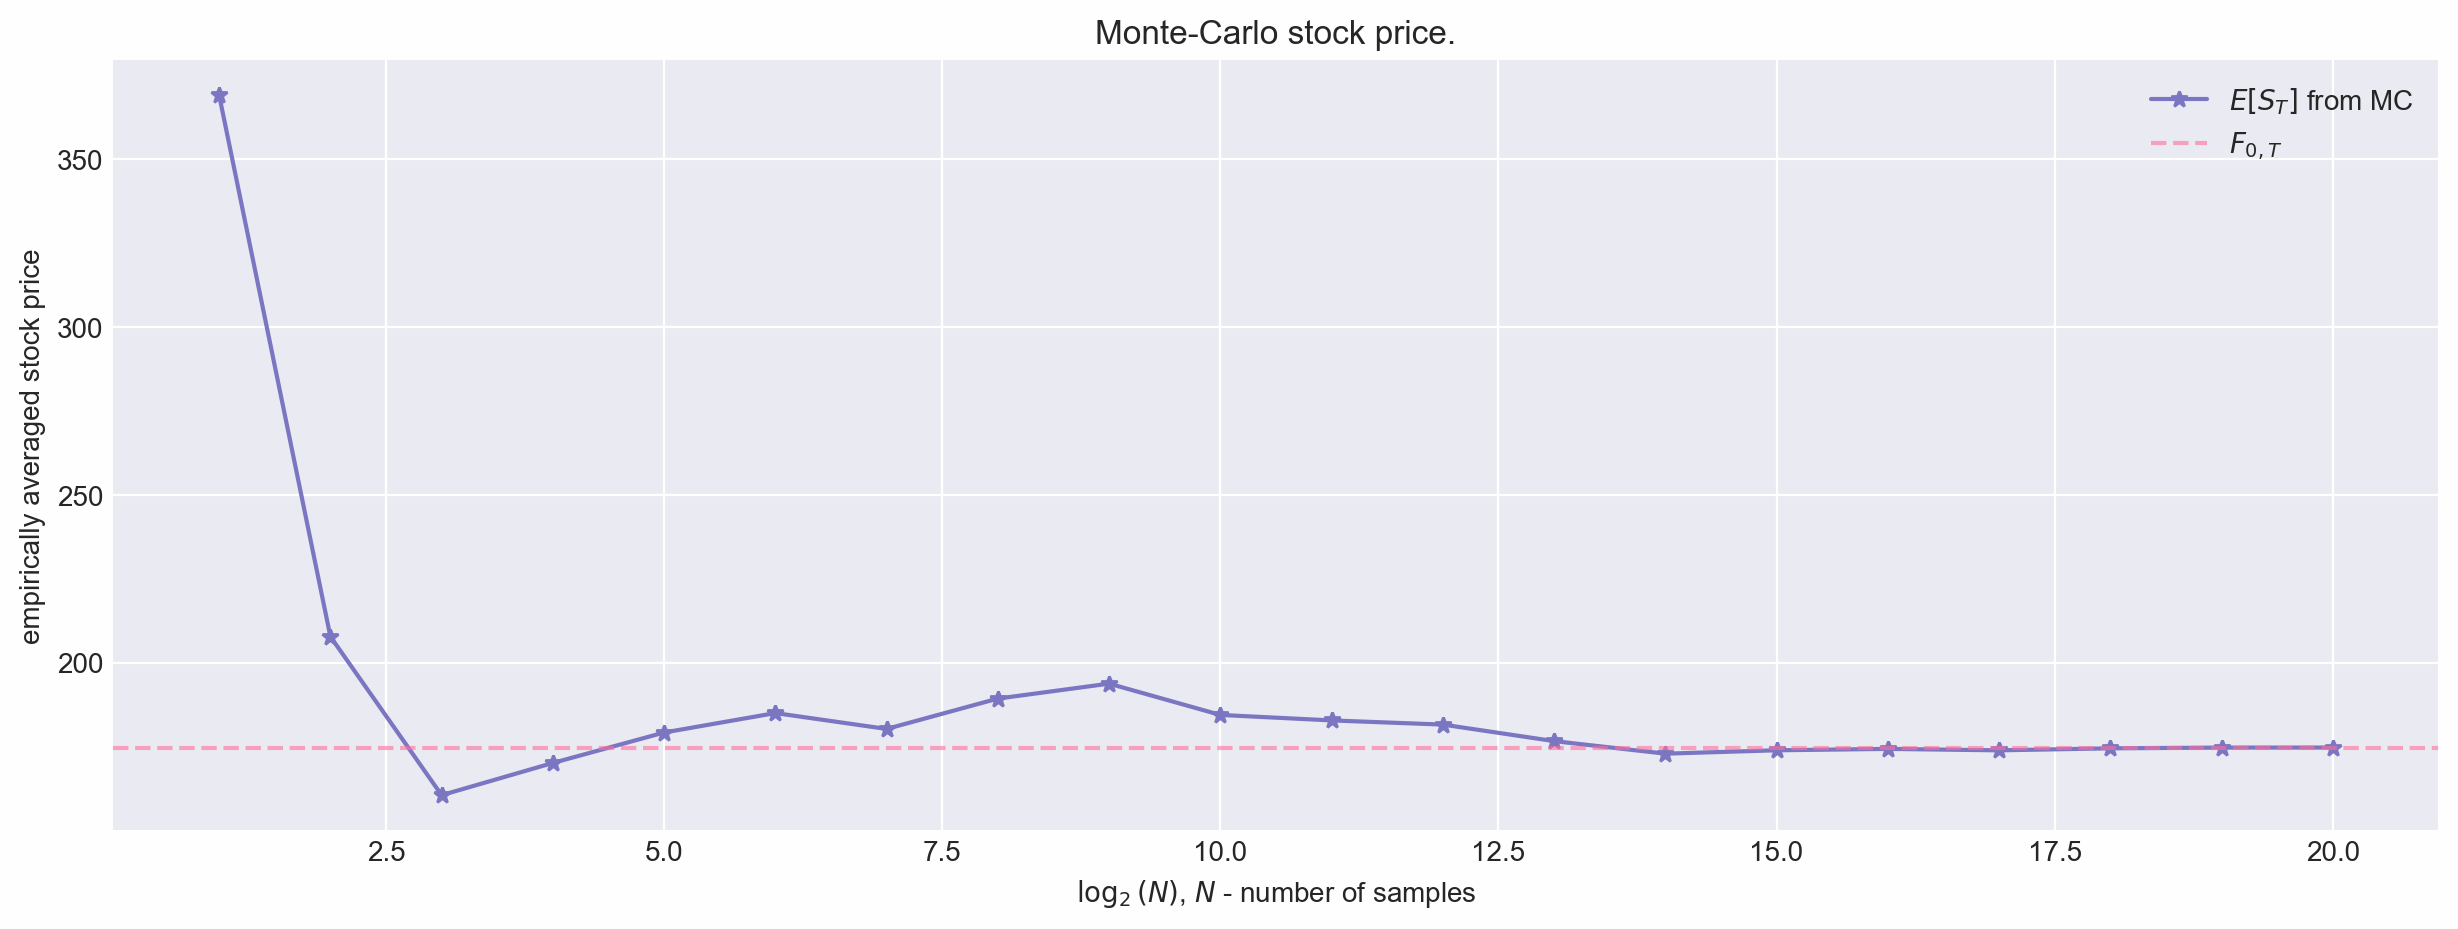

In [37]:

log_2_iteratinos = np.linspace(1, 20, 20)
N = [2**i for i in range(log_2_iteratinos.shape[0])]
F_T = equity_forward_curve(0,T) #F_0_t(S0, r, T, alpha, dates)

mean_ST = []
for n_paths in N:
    ST = mc_S_T(S0, r, sigma, n_paths, fast_dates,p_dates, alpha)
    mean_ST.append(np.mean(ST))

_, ax = plt.subplots(figsize=(15, 5), dpi=200)
ax.plot(log_2_iteratinos, mean_ST, marker = '*', label="$E[S_T]$ from MC")
ax.set_title('Monte-Carlo stock price.')
ax.set_xlabel("$\\log_2(N)$, $N$ - number of samples")
ax.set_ylabel('empirically averaged stock price')
plt.axhline(F_T, color='C1', linestyle='--', label="$F_{0,T}$")
plt.legend()
plt.show()

### 2. Cash Dividend Model approximations (55 points)

Using option prices obtained in the problem above, compute implied volatilities corresponding to each of the following affine approximations of the Cash Dividend Model.  Each of your answers should contain an implied volatilities curve plot.

For each model, make your conclusion about the quality of the approximation. What happens with the implied volatility when the valuation date passes the ex-dividend date? When the option's expiry date passes the ex-div date? 

1. **(10 points)** **Forward (Black) model** 

$$ PV_0 = P(0, T) Black(F_{0,T}, K, \sigma, T).$$

In [38]:
# Повторяем как в предыдущем номере
ivs_forward = []

for i in range(len(mc_prices)):
    try:
        vol = implied_volatility(
            discounted_option_price=mc_prices[i],       
            F = F,           
            K=K[i],       
            r=r,         
            t=T,  # Время до экспирации
            flag='c'  # Тип опциона ('c' - call)
        )
        ivs_forward.append(vol)
    except:
        ivs_forward.append(np.nan)

ivs_forward = np.array(ivs_forward)

2. **(20 points)** **Spot model** 

$$ PV_0 = P(0, T) Black(g(T), K-h(T), \sigma, T).$$

$$g(T) = S_0 * e^{rT} \quad h(T) = - e^{rT}\sum_{i: \tau_i\in (0, T]} d_i e^{-r \tau_i}$$

In [39]:

g_spot = S0 * np.exp(r * T)

future_divs = sum([d * np.exp(-r * (tau)) for d, tau in zip(alphas, p_dates)])
h_spot = -np.exp(r * T)*future_divs


In [40]:
ivs_spot = []

for i in range(len(mc_prices)):
    try:
        vol = implied_volatility(
            discounted_option_price=mc_prices[i],       
            F = g_spot,           
            K=K[i] - h_spot,       
            r=r,         
            t=T,  # Время до экспирации
            flag='c'  # Тип опциона ('c' - call)
        )
        ivs_spot.append(vol)
    except:
        ivs_spot.append(np.nan)

ivs_spot = np.array(ivs_spot)

3. **(25 points)** **Bos-Vandermark model**

$$ PV_0 = P(0, T) Black(g(T), K-h(T), \sigma, T).$$

$$g(T) = (S_0 - \sum _{i:\tau_i \in (0, T]} \frac{T-\tau_i}{T} d_i e^{-r\tau_i})  e^{rT} \quad h(T) = - e^{rT}\sum _{i:\tau_i \in (0, T]} \frac{\tau_i}{T} d_i e^{-r\tau_i}$$

In [41]:
near_divs=sum([(T-tau)/(T)*d*np.exp(-r*(tau)) for d, tau in zip(alphas, p_dates)])
g_bos = (S0-near_divs)*np.exp(r*T)


far_divs=sum([(tau)/(T) *d*np.exp(-r*(tau)) for d, tau in zip(alphas, p_dates)])
h_bos = -np.exp(r*T)*far_divs

In [42]:
ivs_bos = []

for i in range(len(mc_prices)):
    try:
        vol = implied_volatility(
            discounted_option_price=mc_prices[i],       
            F = g_bos,           
            K=K[i]-h_bos,       
            r=r,         
            t=T,  # Время до экспирации
            flag='c'  # Тип опциона ('c' - call)
        )
        ivs_bos.append(vol)
    except:
        ivs_bos.append(np.nan)

ivs_bos = np.array(ivs_bos)

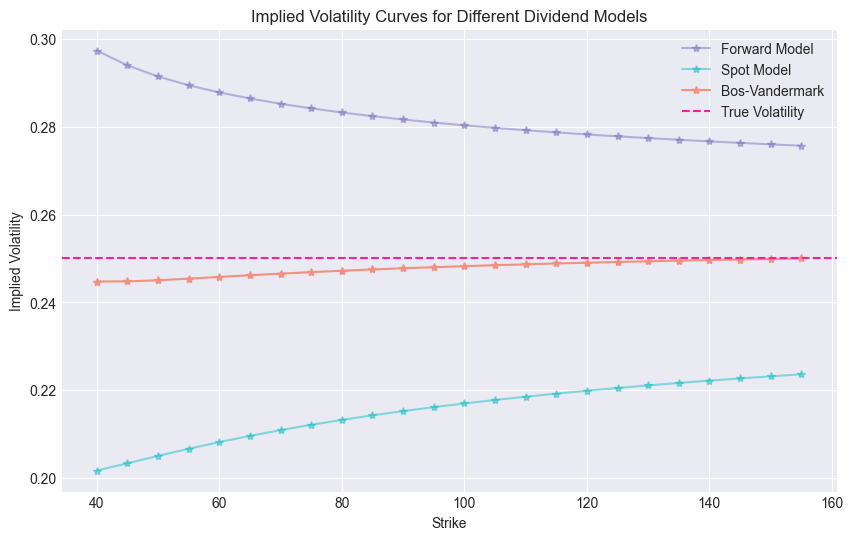

In [43]:
plt.figure(figsize=(10,6))
plt.plot(K, ivs_forward, label="Forward Model", marker='*',alpha = 0.5)
plt.plot(K, ivs_spot, label="Spot Model", color='C3',marker='*', alpha = 0.5)
plt.plot(K, ivs_bos, label="Bos-Vandermark",color='C4', marker='*')
plt.axhline(sigma, linestyle='--', color='C2', label='True Volatility')

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Curves for Different Dividend Models")
plt.legend()
plt.grid(True)
plt.show()

- Forward Model увеличивает результат. 
  -  Минусы: скачки волатильности когда ex-div перед экспирацией
  
  Платим $(S_{\tau-} - K)_+ = (S_{\tau} - (K-d))_+$, где $d$ - кэш дивиденд в момент $\tau$. Предполагается, что $\hat \sigma(\tau -, K) = \hat \sigma(\tau, K-d)$. Но для формулы Блека (возьмем $K = F_{0, \tau-}$): $ PV_0  = Black(F_{0, \tau-},F_{0, \tau-},\hat \sigma(\tau -, F_{0, \tau-})) =  Black(F_{0, \tau},F_{0, \tau},\hat \sigma(\tau, F_{0, \tau})) = \underbrace{\lambda}_{ = 1- \frac{d}{F_{0, \tau-}}} Black(F_{0, \tau-},F_{0, \tau-},\hat \sigma(\tau, F_{0, \tau})) $. 

    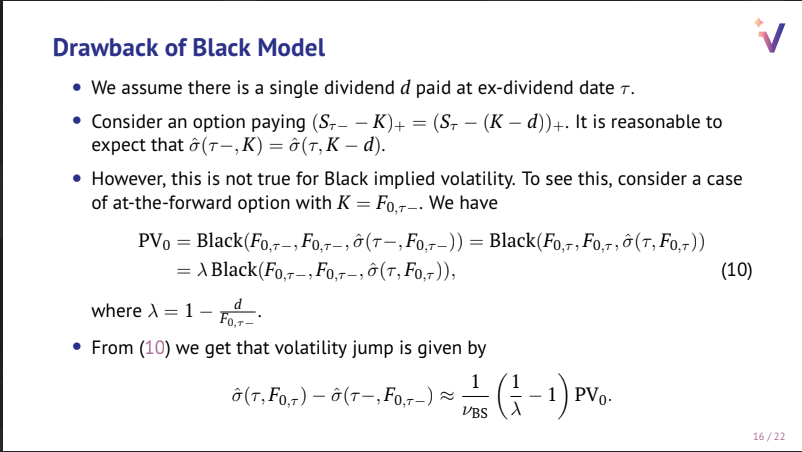

- Spot Model уменьшает результат
    -  Минусы: скачки волатильности когда экспирация опциона перед ex-div

    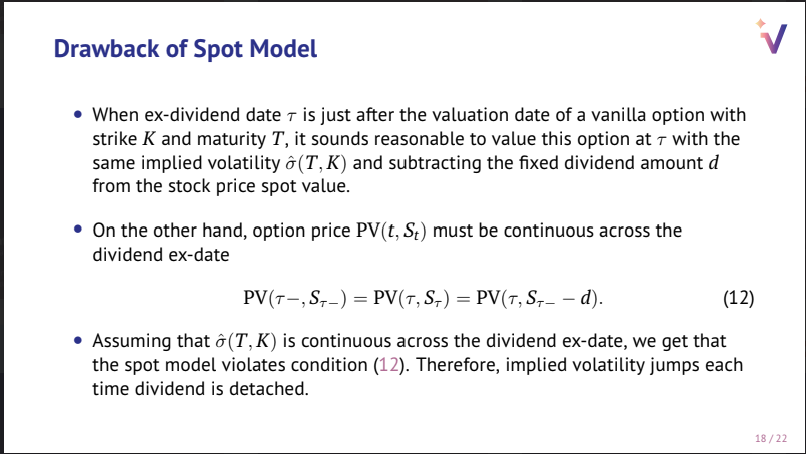
  

- Bos-Vandermark Самый точный из предолженных вариантов. Решает проблемы спот и форвард моделей. Поэтому скачков нет.

    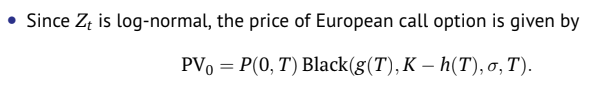

    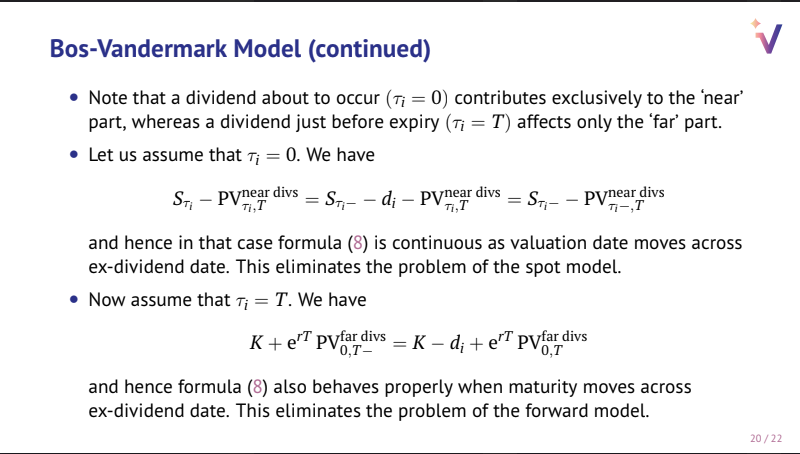
